# Node probing for AIFB dataset and GCN

Here we'll first be loading the dataset and explore its structure

In [98]:
#dataset MUTAG
import numpy as np
import pandas as pd
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Entities
from torch_geometric.transforms import TargetIndegree

# Load the AIFB dataset
dataset = Entities(root='/tmp/AIFB', name='AIFB')
dataset[0]

Data(edge_index=[2, 58086], edge_type=[58086], train_idx=[140], train_y=[140], test_idx=[36], test_y=[36], num_nodes=8285)

In [111]:
import rdflib
from collections import defaultdict

# Load the AIFB dataset
graph = rdflib.Graph()
graph.parse("aifb_dataset.ttl", format="ttl")

# Dictionary to store node labels
node_labels = defaultdict(list)

# Iterate through the triples and extract rdf:type triples
for subj, pred, obj in graph:
    if pred == rdflib.RDF.type:
        node_labels[subj].append(obj)

# Remove rdf:type triples from the graph
graph.remove((None, rdflib.RDF.type, None))

# Print the labels for each node
for node, labels in node_labels.items():
    print(f"Node: {node}, Labels: {labels}")


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_17732\508267560.py", line 6, in <module>
    graph.parse("aifb_dataset.ttl", format="ttl")
  File "c:\Users\tomdu\miniconda3\lib\site-packages\rdflib\graph.py", line 1468, in parse
    source = create_input_source(
  File "c:\Users\tomdu\miniconda3\lib\site-packages\rdflib\parser.py", line 401, in create_input_source
    ) = _create_input_source_from_location(
  File "c:\Users\tomdu\miniconda3\lib\site-packages\rdflib\parser.py", line 461, in _create_input_source_from_location
    file = open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\tomdu\\OneDrive\\Documents\\ENSC_VU\\4A-Vu\\Thesis\\aifb_dataset.ttl'

During handling of the above exception, another exception occurred:

Traceback (most recent call

In [99]:
from torch_geometric.datasets import TUDataset
#utag
mutag = TUDataset(root='/tmp/MUTAG', name='MUTAG')
mutag
mutag[0]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])

In [100]:
data = dataset[0]  # AIFB is a single graph

# Create one-hot encoded node features for the entire dataset
num_nodes = data.num_nodes
data.x = torch.eye(num_nodes)  # One-hot encoding for all nodes


In [101]:
dataset.data = data  # This line ensures the dataset now references the modified data


In [102]:
dataset.data

c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\data\in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(edge_index=[2, 58086], edge_type=[58086], train_idx=[140], train_y=[140], test_idx=[36], test_y=[36], num_nodes=8285, x=[8285, 8285])

Model

In [103]:
#set the seed
torch.manual_seed(37)

MODEL = "GCN"
DATASET = "AIFB"

from models.models_AIFB import GCN_framework as framework # import the model

gnn = framework(dataset)


In [8]:
# gnn.iterate()

In [9]:
# gnn.train()

In [10]:
#save the model 
# gnn.save_model(path="models/"+DATASET+"_"+MODEL+".pt")

In [10]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+".pt")

In [11]:
gnn.evaluate()

Final Evaluation - Train Acc: 1.000, Test Acc: 0.889


### Features / embeddings

```plaintext
[
    (
        Feature shape: torch.Size([8285, 128]), x1,
        Feature shape: torch.Size([8285, 128]), x2,
        Feature shape: torch.Size([8285, 128]), x3,
        Feature shape: torch.Size([8285, 128]), x4,
        Feature shape: torch.Size([8285, 4]), x5
    ),
]

In [8]:
train_features, test_features = gnn.evaluate_with_features2()

Features generated from model, shape of output: [torch.Size([8285, 128]), torch.Size([8285, 128]), torch.Size([8285, 128]), torch.Size([8285, 128]), torch.Size([8285, 4])]
Feature shape: torch.Size([8285, 128]), train_indices max: 8240
Feature shape: torch.Size([8285, 128]), train_indices max: 8240
Feature shape: torch.Size([8285, 128]), train_indices max: 8240
Feature shape: torch.Size([8285, 128]), train_indices max: 8240
Feature shape: torch.Size([8285, 4]), train_indices max: 8240


In [17]:
print(len(train_features[0]))
print(len(test_features[0]))
len(train_features), len(test_features)

140
36


(5, 5)

In [62]:
train_features[0][0].shape

(128,)

In [110]:
#print the possibles classes that we're classifying in train_y of dataset 
print(set(dataset.data.train_y.numpy()))

{0, 1, 2, 3}


### node properties

In [65]:
#we have the train_idx=[140], test_idx=[36]

#we want to calculate the node properties of the train and test nodes such as node degree, clustering coefficient, betweenness centrality, closeness centrality, eigenvector centrality, and pagerank. And get the train_node_properties and test_node_properties

#we will use the networkx library to calculate the node properties
# Convert PyTorch Geometric Data to NetworkX format
import networkx as nx
from torch_geometric.utils import to_networkx
import torch

G = to_networkx(data, to_undirected=True)

# Calculate various node properties using NetworkX
degree = dict(G.degree())
clustering = nx.clustering(G)
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)
eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
pagerank = nx.pagerank(G)


In [66]:

# Create a function to gather properties for specific nodes
def get_node_properties(indices):
    properties = []
    for idx in indices:
        properties.append({
            'degree': degree[idx],
            'clustering': clustering[idx],
            'betweenness': betweenness[idx],
            'closeness': closeness[idx],
            'eigenvector': eigenvector[idx],
            'pagerank': pagerank[idx]
        })
    return properties

# Extract node properties for train and test indices
train_node_properties = get_node_properties(data.train_idx.tolist())
test_node_properties = get_node_properties(data.test_idx.tolist())

# Convert to tensor format if needed
train_node_properties_tensor = {key: torch.tensor([prop[key] for prop in train_node_properties]) for key in train_node_properties[0]}
test_node_properties_tensor = {key: torch.tensor([prop[key] for prop in test_node_properties]) for key in test_node_properties[0]}



## Diagnostic classifier 

#### First try

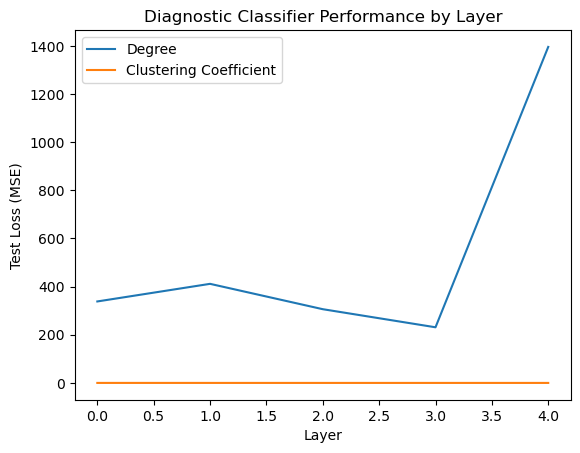

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Assuming train_features, test_features, train_node_properties_tensor, and test_node_properties_tensor are available

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

def train_linear_model(train_x, train_y, test_x, test_y, num_epochs=1000, learning_rate=0.01):
    input_size = train_x.shape[1]
    output_size = train_y.shape[1]

    model = LinearModel(input_size, output_size)
    criterion = nn.MSELoss()  # For regression tasks
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_x)
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_outputs = model(test_x)
        test_loss = criterion(test_outputs, test_y).item()

    return model, test_loss

# Function to evaluate and plot results for each layer and property
def evaluate_layers(train_features, test_features, train_node_properties_tensor, test_node_properties_tensor):
    num_layers = len(train_features)
    num_properties = train_node_properties_tensor.shape[1]

    test_losses = torch.zeros((num_layers, num_properties))

    for layer_idx in range(num_layers):
        for prop_idx in range(num_properties):
            train_x = torch.tensor(train_features[layer_idx])
            test_x = torch.tensor(test_features[layer_idx])
            train_y = train_node_properties_tensor[:, prop_idx].unsqueeze(1)
            test_y = test_node_properties_tensor[:, prop_idx].unsqueeze(1)

            _, test_loss = train_linear_model(train_x, train_y, test_x, test_y)
            test_losses[layer_idx, prop_idx] = test_loss

    # Plotting the results
    property_names = ['Degree', 'Clustering Coefficient']  # Adjust according to your properties
    for prop_idx in range(num_properties):
        plt.plot(range(num_layers), test_losses[:, prop_idx].numpy(), label=f"{property_names[prop_idx]}")

    plt.xlabel("Layer")
    plt.ylabel("Test Loss (MSE)")
    plt.title("Diagnostic Classifier Performance by Layer")
    plt.legend()
    plt.show()

# Now evaluate and plot the results
evaluate_layers(train_features, test_features, train_node_properties_tensor, test_node_properties_tensor)


In [52]:
train_features[0][139]

array([ 1.3555768 , -0.2241855 , -0.18257284, -0.2737489 ,  1.3292845 ,
       -1.0234201 ,  1.5573556 ,  1.2646968 , -0.21248208, -0.5439213 ,
        0.14268374, -1.0055735 , -0.19394766, -0.5898287 ,  3.42712   ,
       -0.52868223, -0.756886  , -0.39360148, -0.70778924, -0.9648495 ,
       -0.39419457, -0.58542466,  1.9438896 ,  1.2779977 ,  3.3278584 ,
       -0.4534662 , -0.7998004 , -0.31150052,  1.2959744 , -0.5668221 ,
        0.9298318 ,  1.8480177 , -0.79953223, -1.0220441 ,  1.4006733 ,
       -0.24722424, -0.5150197 , -0.771422  , -0.30894232, -0.1736691 ,
        1.2043242 , -0.6904449 , -0.80797184, -0.26802537, -0.94709486,
       -0.60023254, -0.38798   , -0.9344617 ,  0.09242868, -0.5018424 ,
        0.69517636, -0.9876125 ,  0.98329353, -1.0271348 , -0.545658  ,
        0.42941514,  0.04523568, -0.61728716, -0.6893512 , -0.96952766,
       -0.2916307 , -0.04117952,  1.0595467 , -1.1335886 , -1.3392901 ,
        1.7542977 ,  0.18756652, -0.4467741 , -0.41738206, -0.36

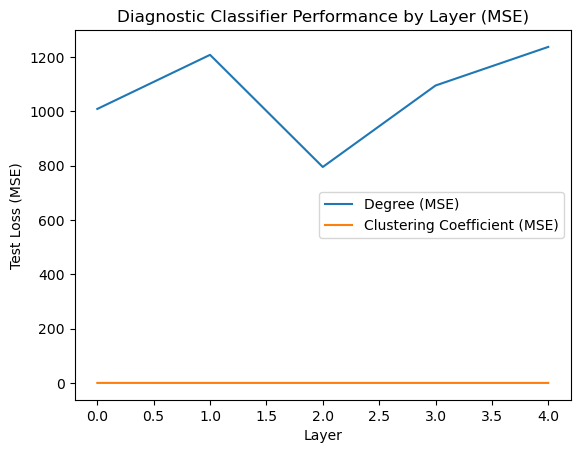

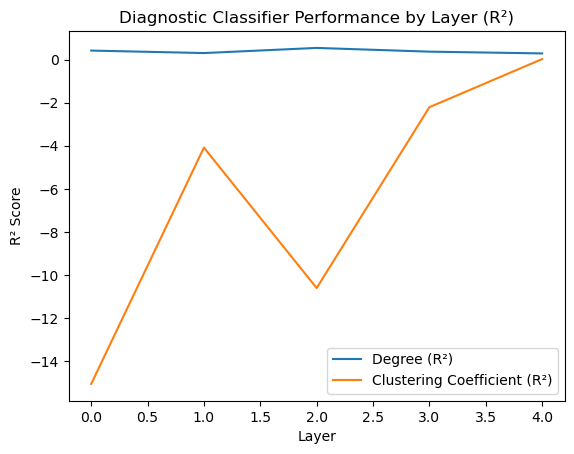

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

def train_linear_model(train_x, train_y, test_x, test_y, num_epochs=10000, learning_rate=0.01):
    input_size = train_x.shape[1]
    output_size = train_y.shape[1]

    model = LinearModel(input_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_x)
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_outputs = model(test_x)
        test_loss = criterion(test_outputs, test_y).item()
        r2 = r2_score(test_y.cpu().numpy(), test_outputs.cpu().numpy())

    return model, test_loss, r2

def evaluate_layers(train_features, test_features, train_node_properties_tensor, test_node_properties_tensor):
    num_layers = len(train_features)
    num_properties = train_node_properties_tensor.shape[1]

    test_losses = torch.zeros((num_layers, num_properties))
    r2_scores = torch.zeros((num_layers, num_properties))

    for layer_idx in range(num_layers):
        for prop_idx in range(num_properties):
            train_x = torch.tensor(train_features[layer_idx])
            test_x = torch.tensor(test_features[layer_idx])
            train_y = train_node_properties_tensor[:, prop_idx].unsqueeze(1)
            test_y = test_node_properties_tensor[:, prop_idx].unsqueeze(1)

            _, test_loss, r2 = train_linear_model(train_x, train_y, test_x, test_y)
            test_losses[layer_idx, prop_idx] = test_loss
            r2_scores[layer_idx, prop_idx] = r2

    # Plotting the results for MSE loss
    property_names = ['Degree', 'Clustering Coefficient']  # Adjust according to your properties
    for prop_idx in range(num_properties):
        plt.plot(range(num_layers), test_losses[:, prop_idx].numpy(), label=f"{property_names[prop_idx]} (MSE)")

    plt.xlabel("Layer")
    plt.ylabel("Test Loss (MSE)")
    plt.title("Diagnostic Classifier Performance by Layer (MSE)")
    plt.legend()
    plt.show()

    # Plotting the results for R² score
    for prop_idx in range(num_properties):
        plt.plot(range(num_layers), r2_scores[:, prop_idx].numpy(), label=f"{property_names[prop_idx]} (R²)")

    plt.xlabel("Layer")
    plt.ylabel("R² Score")
    plt.title("Diagnostic Classifier Performance by Layer (R²)")
    plt.legend()
    plt.show()

# Now evaluate and plot the results
evaluate_layers(train_features, test_features, train_node_properties_tensor, test_node_properties_tensor)


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

def train_linear_model_single_node(train_x, train_y, test_x, test_y, num_epochs=100, learning_rate=0.01):
    input_size = train_x.shape[0]  # The size of the vector representation of a single node
    output_size = 1  # Since we're predicting a scalar property

    model = LinearModel(input_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Add a batch dimension to the inputs
    train_x = train_x.unsqueeze(0)  # Shape becomes (1, input_size)
    train_y = torch.tensor([[train_y]])  # Shape becomes (1, 1)
    test_x = test_x.unsqueeze(0)  # Shape becomes (1, input_size)
    test_y = torch.tensor([[test_y]])  # Shape becomes (1, 1)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_x)
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_outputs = model(test_x)
        test_loss = criterion(test_outputs, test_y).item()
        r2 = r2_score(test_y.cpu().numpy(), test_outputs.cpu().numpy())

    return model, test_loss, r2

def evaluate_layers(train_features, test_features, train_node_properties_tensor, test_node_properties_tensor):
    num_layers = len(train_features)
    num_properties = train_node_properties_tensor.shape[1]

    test_losses = torch.zeros((num_layers, num_properties))
    r2_scores = torch.zeros((num_layers, num_properties))

    for layer_idx in range(num_layers):
        for prop_idx in range(num_properties):
            layer_train_features = train_features[layer_idx]  # Shape: (140, 128)
            layer_test_features = test_features[layer_idx]    # Shape: (36, 128)

            train_y = train_node_properties_tensor[:, prop_idx]  # Shape: (140,)
            test_y = test_node_properties_tensor[:, prop_idx]    # Shape: (36,)

            # Initialize lists to collect losses and R² scores for each node
            losses = []
            r2_scores_per_node = []

            # Train and evaluate on each node individually
            for node_idx in range(layer_train_features.shape[0]):
                train_x = torch.tensor(layer_train_features[node_idx])  # Shape: (128,)
                train_property = train_y[node_idx].item()  # Convert to scalar

                test_x = torch.tensor(layer_test_features[node_idx])  # Shape: (128,)
                test_property = test_y[node_idx].item()  # Convert to scalar

                _, test_loss, r2 = train_linear_model_single_node(train_x, train_property, test_x, test_property)
                losses.append(test_loss)
                r2_scores_per_node.append(r2)

            # Average loss and R² scores over all nodes for this property and layer
            test_losses[layer_idx, prop_idx] = torch.tensor(losses).mean()
            r2_scores[layer_idx, prop_idx] = torch.tensor(r2_scores_per_node).mean()

    # Plotting the results for MSE loss
    property_names = ['Degree', 'Clustering Coefficient']  # Adjust according to your properties
    for prop_idx in range(num_properties):
        plt.plot(range(num_layers), test_losses[:, prop_idx].numpy(), label=f"{property_names[prop_idx]} (MSE)")

    plt.xlabel("Layer")
    plt.ylabel("Test Loss (MSE)")
    plt.title("Diagnostic Classifier Performance by Layer (MSE)")
    plt.legend()
    plt.show()

    # Plotting the results for R² score
    for prop_idx in range(num_properties):
        plt.plot(range(num_layers), r2_scores[:, prop_idx].numpy(), label=f"{property_names[prop_idx]} (R²)")

    plt.xlabel("Layer")
    plt.ylabel("R² Score")
    plt.title("Diagnostic Classifier Performance by Layer (R²)")
    plt.legend()
    plt.show()

# Now evaluate and plot the results
evaluate_layers(train_features, test_features, train_node_properties_tensor, test_node_properties_tensor)


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Unexpected exception formatting exception. Falling back to standard exception


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_16156\2105161642.py", line 102, in <module>
    evaluate_layers(train_features, test_features, train_node_properties_tensor, test_node_properties_tensor)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_16156\2105161642.py", line 69, in evaluate_layers
    test_x = torch.tensor(layer_test_features[node_idx])  # Shape: (128,)
Index

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

class LinearModel(nn.Module):
    def __init__(self, input_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

def train_probe_for_node(features, property_value, num_epochs=100, learning_rate=0.01):
    model = LinearModel(features.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    features = features.unsqueeze(0)  # Add batch dimension if it's not there
    property_value = torch.tensor([property_value], dtype=torch.float32).unsqueeze(0)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(features)
        loss = criterion(output, property_value)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        pred = model(features)
        mse = criterion(pred, property_value).item()
        r2 = r2_score(property_value.cpu().numpy(), pred.cpu().numpy())

    return mse, r2

def evaluate_node_probes(train_features, test_features, train_properties, test_properties):
    num_layers = len(train_features)
    results = []

    for layer_idx in range(num_layers):
        layer_train_features = train_features[layer_idx]
        layer_test_features = test_features[layer_idx]
        
        # Iterate over each node for training
        mse_scores, r2_scores = [], []
        for node_idx, node_features in enumerate(layer_train_features):
            node_property = train_properties[node_idx]
            mse, r2 = train_probe_for_node(node_features, node_property['degree'])  # Example for 'degree'
            mse_scores.append(mse)
            r2_scores.append(r2)
        
        results.append({
            'layer': layer_idx,
            'mse_scores': mse_scores,
            'r2_scores': r2_scores
        })
    
    # Plotting the results
    for result in results:
        layer = result['layer']
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.hist(result['mse_scores'], bins=30)
        plt.title(f'Layer {layer} - MSE Distribution')
        plt.xlabel('MSE Score')
        plt.ylabel('Frequency')

        plt.subplot(1, 2, 2)
        plt.hist(result['r2_scores'], bins=30)
        plt.title(f'Layer {layer} - R² Score Distribution')
        plt.xlabel('R² Score')
        plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()


evaluate_node_probes(train_features, test_features, train_node_properties, test_node_properties)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_16156\1821916416.py", line 81, in <module>
    evaluate_node_probes(train_features, test_features, train_node_properties, test_node_properties)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_16156\1821916416.py", line 51, in evaluate_node_probes
    mse, r2 = train_probe_for_node(node_features, node_property['degree'])  # Example for 'degree'
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_16156\1821916416.py", line 16, in train_probe_for_node
    model = LinearModel(features.shape[1])
IndexError: tuple index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2105, in showtr

#### One classifier per node to select the nodes that seem to be encoded in the representations

Training on Single Data points :
The way train_probe_for_node is structured, it seems to be training on a single data point at a time (each node's features), which was fine because intended, but it's crucial to understand that this will lead to very limited learning. In such a case, R² might not be meaningful as it’s computed over a single sample.

Training on multiple data points : 
The goal now is to train on multiple data points with one linear classifier : 
Features are typically of the shape :


```plaintext
[
    (
        Feature shape: torch.Size([8285, 128]), x1,
        Feature shape: torch.Size([8285, 128]), x2,
        Feature shape: torch.Size([8285, 128]), x3,
        Feature shape: torch.Size([8285, 128]), x4,
        Feature shape: torch.Size([8285, 4]), x5
    ),
]


as they are a list of layer embeddings. Each layer has a list of node embeddings (140 node in the train_features for exemple) and each node has a vector of 128 features that represent it. We want to plot the R2 scores of the different properties in the different layers. To change this point we need to pass from the paradigm where we probe each node with a different probe to a paradigm where we have one probe for each property and each layer, and we train it on the train set and test it on the test set. 

code a bit more modular to plot afterwards

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np

class LinearModel(nn.Module):
    def __init__(self, input_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

def train_probe_for_node(features, property_value, num_epochs=1000, learning_rate=0.01):
    # Convert features to PyTorch tensor if it's a NumPy array
    if isinstance(features, np.ndarray):
        features = torch.tensor(features, dtype=torch.float32)

    # Ensure it's 2D: (1, feature_size)
    if len(features.shape) == 1:
        features = features.unsqueeze(0)
    
    print(f"Training on features with shape: {features.shape} for property value: {property_value}")

    model = LinearModel(features.shape[1])  # Features should be 2D: (1, feature_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Convert property_value to PyTorch tensor
    property_value = torch.tensor([property_value], dtype=torch.float32).unsqueeze(0)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(features)
        loss = criterion(output, property_value)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        pred = model(features)
        mse = criterion(pred, property_value).item()
        r2 = r2_score(property_value.cpu().numpy(), pred.cpu().numpy())

    return mse, r2

def evaluate_node_probes(train_features, test_features, train_properties, test_properties):
    num_layers = len(train_features)
    results = []

    for layer_idx in range(num_layers):
        layer_train_features = train_features[layer_idx]
        layer_test_features = test_features[layer_idx]
        
        # Iterate over each node for training
        mse_scores, r2_scores = [], []
        for node_idx, node_features in enumerate(layer_train_features):
            node_property = train_properties[node_idx]
            mse, r2 = train_probe_for_node(node_features, node_property['degree'])  # Example for 'degree'
            mse_scores.append(mse)
            r2_scores.append(r2)
        
        results.append({
            'layer': layer_idx,
            'mse_scores': mse_scores,
            'r2_scores': r2_scores
        })
    
    return results

def plot_results(results):
    for result in results:
        layer = result['layer']
        plt.figure(figsize=(10, 4))
        
        # Plot MSE Distribution
        plt.subplot(1, 2, 1)
        plt.hist(result['mse_scores'], bins=30)
        plt.title(f'Layer {layer} - MSE Distribution')
        plt.xlabel('MSE Score')
        plt.ylabel('Frequency')

        # Clean up r2_scores by removing NaNs
        clean_r2_scores = [r2 for r2 in result['r2_scores'] if not np.isnan(r2)]

        # Plot R² Score Distribution
        plt.subplot(1, 2, 2)
        if clean_r2_scores:  # Only plot if we have valid R² scores
            plt.hist(clean_r2_scores, bins=30)
            plt.title(f'Layer {layer} - R² Score Distribution')
            plt.xlabel('R² Score')
            plt.ylabel('Frequency')
        else:
            plt.title(f'Layer {layer} - No valid R² scores')
            plt.xlabel('R² Score')
            plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()

# Assuming train_features, test_features, train_properties, test_properties are already defined
results = evaluate_node_probes(train_features, test_features, train_node_properties, test_node_properties)

Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 32


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 125


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 67


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 38


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 21


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 35


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 25


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 83


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 252


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 34


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 64


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 52


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 60


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 79


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 22


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 85


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 33


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 66


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 43


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 30


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 202


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 18


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 32


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 125


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 67


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 38


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 21


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 35


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 25


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 83


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 252


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 34


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 64


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 52


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 60


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 79


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 22


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 85


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 33


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 66


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 43


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 30


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 202


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 18


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 32


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 125


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 67


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 38


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 21


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 35


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 25


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 83


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 252


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 34


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 64


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 52


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 60


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 79


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 22


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 85


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 33


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 66


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 43


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 30


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 202


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 18


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 32


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 125


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 67


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 38


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 21


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 35


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 25


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 83


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 252


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 34


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 64


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 52


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 60


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 79


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 22


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 85


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 33


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 66


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 43


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 30


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 202


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 18


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 32


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 125


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 67


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 38


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 21


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 35


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 25


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 83


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 252


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 34


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 64


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 52


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 60


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 79


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 22


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 85


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 33


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 66


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 43


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 30


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 202


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 18


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


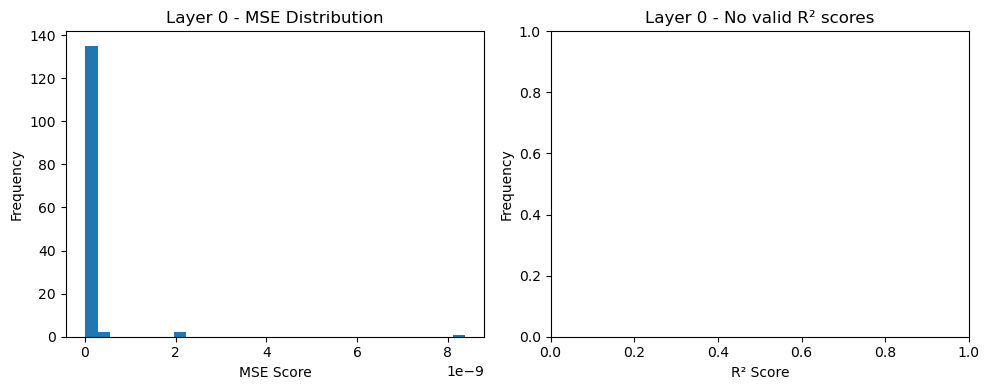

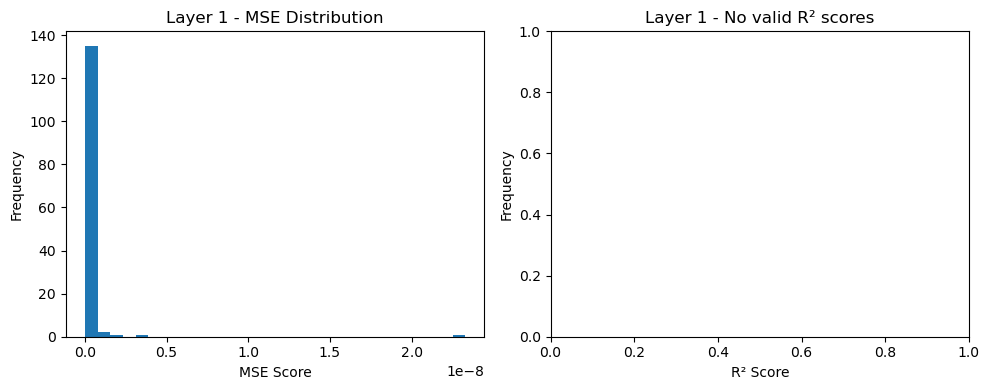

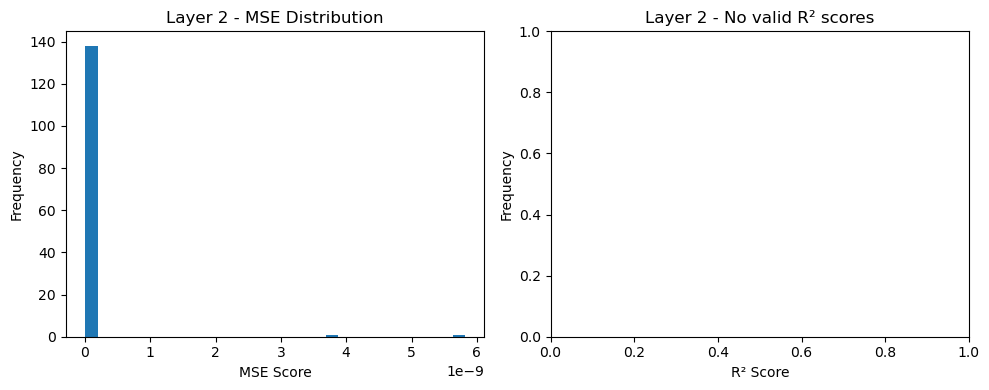

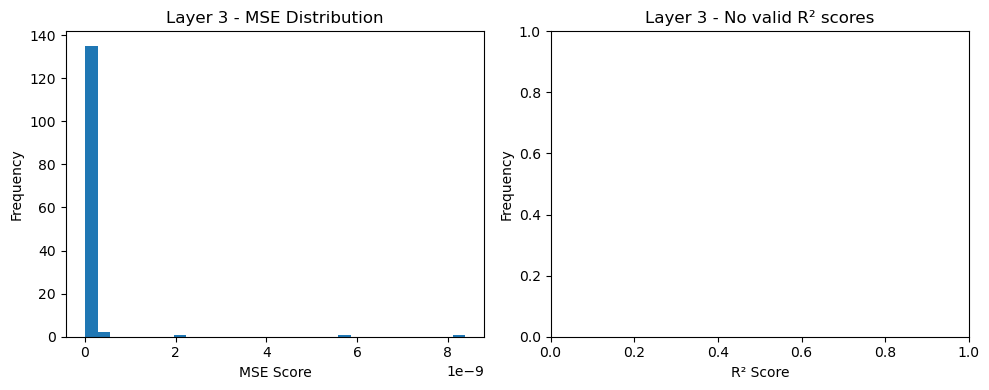

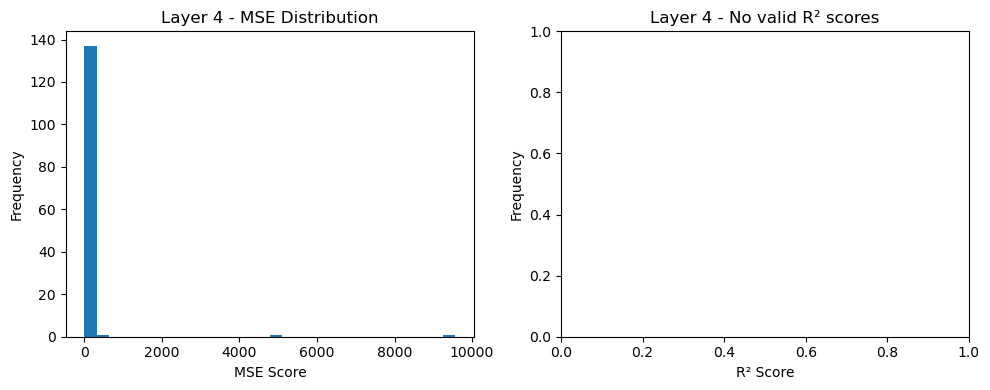

In [23]:
# In another cell
plot_results(results)

Conclusion : it seems we can learn for all the nodes their node degree, except one or two nodes which might not have their node degree encoded in their representation because they are not usefull for the classification. Maybe disconnected nodes or something similar. Let's explore this 

In [ ]:
results

In [45]:
#find the node indexes where the MSE score is bigger than 1
def find_bad_nodes(results):
    bad_nodes = []
    for result in results:
        for idx, mse in enumerate(result['mse_scores']):
            if mse > 1:
                bad_nodes.append((result['layer'], idx))
    return bad_nodes

bad_nodes = find_bad_nodes(results)
print(bad_nodes)

#link these indexes to the real node indexes data.train_idx.tolist()
bad_nodes_real = [(data.train_idx.tolist()[node_idx], layer) for layer, node_idx in bad_nodes]
print(bad_nodes_real)

[(4, 12), (4, 53), (4, 56), (4, 66), (4, 76), (4, 82), (4, 97), (4, 99), (4, 112), (4, 136)]
[(5117, 4), (3994, 4), (4451, 4), (4027, 4), (3378, 4), (251, 4), (1102, 4), (2028, 4), (3721, 4), (6187, 4)]


In [53]:
#check the node properties of the bad nodes
bad_node_properties = get_node_properties([node_idx for node_idx, _ in bad_nodes_real])
print(bad_node_properties)

[{'degree': 125, 'clustering': 0}, {'degree': 78, 'clustering': 0.014985014985014986}, {'degree': 83, 'clustering': 0.05495151337055539}, {'degree': 252, 'clustering': 0.013944223107569721}, {'degree': 95, 'clustering': 0.006270996640537514}, {'degree': 95, 'clustering': 0.08107502799552072}, {'degree': 79, 'clustering': 0.0759493670886076}, {'degree': 85, 'clustering': 0.034453781512605045}, {'degree': 202, 'clustering': 0.04920939855179548}, {'degree': 78, 'clustering': 0.023643023643023644}]


In [59]:
#find the good nodes by filtering the bad nodes thanks to their index
good_nodes = [node for node in data.train_idx.tolist() if node not in [node_idx for node_idx, _ in bad_nodes_real]]
print(good_nodes)

#check the node properties of the good nodes
good_node_properties = get_node_properties(good_nodes)
print(good_node_properties)

#max degree of the good nodes
max_degree = max([prop['degree'] for prop in good_node_properties])
print(max_degree)

[2862, 2570, 153, 2146, 7403, 2555, 3013, 684, 6472, 7745, 6704, 3944, 6953, 3926, 6084, 948, 269, 6766, 1145, 4726, 4543, 3537, 90, 186, 2941, 2179, 170, 2894, 1593, 6820, 49, 7477, 8055, 8219, 8030, 1345, 4402, 4651, 8229, 279, 104, 7844, 6275, 4845, 3970, 4572, 1862, 1298, 5268, 6627, 795, 6378, 854, 3135, 1535, 329, 3759, 7950, 5709, 1509, 2764, 2893, 3216, 3168, 6925, 4769, 5307, 7554, 1558, 2136, 1746, 6431, 6121, 194, 1973, 979, 388, 4317, 5214, 3699, 1556, 2237, 4538, 8144, 3524, 7858, 378, 2879, 3790, 3967, 1440, 3536, 5172, 4868, 1056, 5727, 8010, 11, 4847, 1893, 8020, 5279, 3827, 8133, 5208, 3960, 5873, 5356, 4870, 3903, 8135, 1374, 4474, 3279, 5990, 5942, 1962, 7804, 3081, 1919, 3082, 2, 451, 692, 8035, 3366, 3547, 8240, 4634, 491]
[{'degree': 3, 'clustering': 0}, {'degree': 17, 'clustering': 0}, {'degree': 17, 'clustering': 0.0661764705882353}, {'degree': 20, 'clustering': 0.11578947368421053}, {'degree': 4, 'clustering': 0}, {'degree': 5, 'clustering': 0}, {'degree': 3, '

Conclusion bis : seems like 78 is the limit from which we can't predict the node degree anymore. Weird.

## Probe for different properties with a one classifier per property across all nodes

The code aggregates all node embeddings within a layer into a single feature matrix. It then trains a single linear model (probe) to predict the corresponding property values (e.g., "degree") across all nodes in that layer. This means the probe is treating the layer as a whole and learning to map the entire layer's embedding space to the property values collectively. This approach is more about understanding how the entire layer's representation relates to the properties collectively.

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np

class LinearModel(nn.Module):
    def __init__(self, input_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

def train_probe_for_layer(features, property_values, test_features, test_property_values, num_epochs=10000, learning_rate=0.01):
    # Convert features and property values to PyTorch tensors if they are NumPy arrays
    if isinstance(features, np.ndarray):
        features = torch.tensor(features, dtype=torch.float32)
    if isinstance(property_values, np.ndarray):
        property_values = torch.tensor(property_values, dtype=torch.float32)

    if isinstance(test_features, np.ndarray):
        test_features = torch.tensor(test_features, dtype=torch.float32)
    if isinstance(test_property_values, np.ndarray):
        test_property_values = torch.tensor(test_property_values, dtype=torch.float32)

    print(f"Training on features with shape: {features.shape} for property values shape: {property_values.shape}")

    model = LinearModel(features.shape[1])  # Features should be 2D: (num_nodes, feature_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(features).squeeze()  # Remove single-dimensional entries
        loss = criterion(output, property_values)
        loss.backward()
        optimizer.step()

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        pred = model(test_features).squeeze()
        mse = criterion(pred, test_property_values).item()
        # Flatten the tensors for proper use of r2_score
        r2 = r2_score(test_property_values.cpu().numpy(), pred.cpu().numpy())

    return mse, r2

def evaluate_layer_probes(train_features, test_features, train_properties, test_properties):
    num_layers = len(train_features)
    results = []

    for layer_idx in range(num_layers):
        layer_train_features = train_features[layer_idx]
        layer_test_features = test_features[layer_idx]

        # Stack node features into a single matrix for each layer
        train_feature_matrix = np.vstack(layer_train_features)  # Shape: (num_nodes, feature_size)
        test_feature_matrix = np.vstack(layer_test_features)

        # Train and evaluate probe for each property
        for property_name in train_properties[0].keys():  # Assuming all nodes have the same properties
            train_property_values = np.array([node[property_name] for node in train_properties])
            test_property_values = np.array([node[property_name] for node in test_properties])

            mse, r2 = train_probe_for_layer(train_feature_matrix, train_property_values, test_feature_matrix, test_property_values)
            
            results.append({
                'layer': layer_idx,
                'property': property_name,
                'mse': mse,
                'r2': r2
            })

    return results

def plot_results(results):
    layers = sorted(set(result['layer'] for result in results))
    properties = sorted(set(result['property'] for result in results))
    
    plt.figure(figsize=(12, 6))  # Increase the figure size for better readability
    
    for property_name in properties:
        r2_scores = []
        for layer in layers:
            layer_results = [r for r in results if r['layer'] == layer and r['property'] == property_name]
            # Calculate mean R² score for the layer
            mean_r2 = np.mean([r['r2'] for r in layer_results])
            # Set any R² value below -0.05 to -0.05
            if mean_r2 < -0.05:
                mean_r2 = -0.05
            r2_scores.append(mean_r2)
        
        # Plot the R² scores with crosses and lines
        plt.plot(layers, r2_scores, marker='x', linestyle='-', label=property_name)

    # Set the x-ticks to be the layer names
    plt.xticks(ticks=layers, labels=[f'Layer {layer}' for layer in layers])

    plt.title('R² Scores Across Layers for Different Properties')
    plt.xlabel('Layer')
    plt.ylabel('R² Score')
    plt.legend()
    plt.grid(True)  # Add grid for better visibility of points and lines
    plt.show()

# Assuming train_features, test_features, train_properties, test_properties are already defined
results = evaluate_layer_probes(train_features, test_features, train_node_properties, test_node_properties)



Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Size([140])
Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Size([140])
Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Size([140])
Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Size([140])
Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Size([140])
Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Size([140])
Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Size([140])
Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Size([140])
Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Size([140])
Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Si

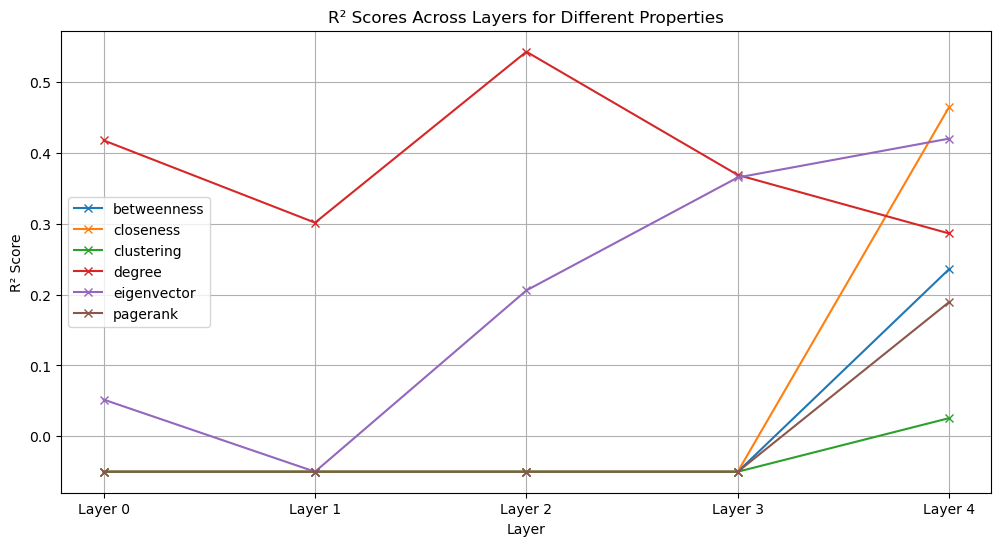

In [68]:
plot_results(results)

In [69]:
train_node_properties

[{'degree': 3,
  'clustering': 0,
  'betweenness': 0.00026100875107330383,
  'closeness': 0.2944942553300086,
  'eigenvector': 0.0010154048293499042,
  'pagerank': 9.80311622657992e-05},
 {'degree': 17,
  'clustering': 0,
  'betweenness': 0.0008793453142243213,
  'closeness': 0.29890619410340863,
  'eigenvector': 0.0038378076701534357,
  'pagerank': 0.0003201736129478911},
 {'degree': 17,
  'clustering': 0.0661764705882353,
  'betweenness': 0.001788790494165879,
  'closeness': 0.3031301659475937,
  'eigenvector': 0.0029529074536590203,
  'pagerank': 0.0003830262972755969},
 {'degree': 20,
  'clustering': 0.11578947368421053,
  'betweenness': 0.0018258904084425993,
  'closeness': 0.29763832211289126,
  'eigenvector': 0.0031404024622116054,
  'pagerank': 0.0004114307998602711},
 {'degree': 4,
  'clustering': 0,
  'betweenness': 0.00026934023305576514,
  'closeness': 0.294578073248133,
  'eigenvector': 0.001023078283639497,
  'pagerank': 0.00011636507663286377},
 {'degree': 5,
  'clusteri